# Week 2: TensorFlow and Deep Learning

This week we will be using Tensorboard to visualize the training of a neural network. We will also be using torch to build a neural network to classify images of clothing. This data set is called Fashion MNIST and is a drop-in replacement for the MNIST dataset. It has 10 classes of clothing items.

In [1]:
import torch as t
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt


## Load in the data, analize and visualize it

In [2]:
# Load the MINST clothing dataset
data = tv.datasets.FashionMNIST(root='./data', train=True, download=True, transform=tv.transforms.ToTensor())

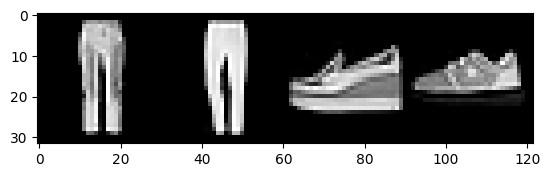

In [3]:
## Create a dataloader
data_loader = t.utils.data.DataLoader(data, batch_size=4, shuffle=True)

## Get the first batch
data_iter = iter(data_loader)
images, labels = next(data_iter)

## Display the images
img = tv.utils.make_grid(images)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

## Define the model

In [4]:
# Define the model

class Net(t.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = t.nn.Conv2d(1, 6, 5) # 1 input channel, 6 output channels, 5x5 kernel. Output size = (input_size - kernel_size + 1) / stride 
        self.pool = t.nn.MaxPool2d(2, 2)
        self.conv2 = t.nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 kernel. Output size = (input_size - kernel_size + 1) / stride
        self.fc1 = t.nn.Linear(16 * 4 * 4, 120)
        self.fc2 = t.nn.Linear(120, 84)
        self.fc3 = t.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(t.nn.functional.relu(self.conv1(x)))
        x = self.pool(t.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = t.nn.functional.relu(self.fc1(x))
        x = t.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

in bash run `tensorboard --logdir=runs` to start tensorboard. Be sure to be in the same directory as the runs folder.

In [15]:
# Create the model
net = Net()

# Define the loss function
criterion = t.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = t.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

number_of_epochs = 2

# Log the model to TensorBoard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.add_graph(net, images)
# Set run name
writer.add_text('run name', 'first run')
# Set run date
writer.add_text('run date', '2020-04-15')
# Set run description
writer.add_text('run description', 'First run of the model')
# Set run parameters
writer.add_text('run parameters', 'lr=0.001, momentum=0.9')
# Set run hyperparameters
writer.add_text('run hyperparameters', 'batch_size=4, shuffle=True')
# Set run metrics
writer.add_text('run metrics', 'accuracy, loss')
# Set run environment
writer.add_text('run environment', 'local')
# Set run tags
writer.add_text('run tags', 'first_run, model, training')
# Set run notes
writer.add_text('run notes', 'First run of the model')
# Set run model
writer.add_text('run model', 'Net')
# Set run dataset
writer.add_text('run dataset', 'FashionMNIST')
# Set run dataset size
writer.add_text('run dataset size', '60,000')
# Set run dataset classes
writer.add_text('run dataset classes', 'T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot')
# Set run dataset description
writer.add_text('run dataset description', 'FashionMNIST dataset')

for name, param in net.named_parameters():
    writer.add_histogram(name, param, 0)

writer.close()



# Train the model and log the loss to TensorBoard
for epoch in range(number_of_epochs):
    running_loss = 0.0
    for i, data in enumerate(data_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            for name, param in net.named_parameters():
                writer.add_histogram(name, param, epoch * len(data_loader) + i)
        # Log the loss to TensorBoard and log what epoch and batch the loss is from
        writer.add_scalar('training loss', running_loss, epoch * len(data_loader) + i)
        # Log the weights to TensorBoard

        
print('Finished Training')
writer.flush()
writer.close()

[1,  2000] loss: 1.539
[1,  4000] loss: 0.790
[1,  6000] loss: 0.656
[1,  8000] loss: 0.599
[1, 10000] loss: 0.547
[1, 12000] loss: 0.502
[1, 14000] loss: 0.485
[2,  2000] loss: 0.455
[2,  4000] loss: 0.441
[2,  6000] loss: 0.417
[2,  8000] loss: 0.409
[2, 10000] loss: 0.414
[2, 12000] loss: 0.415
[2, 14000] loss: 0.390
Finished Training


In [16]:
# run this when an error occurs
writer.flush()
writer.close()

Save, load and evaluate the model

/tmp/ipykernel_818/2938558973.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(t.load('model.pth'))


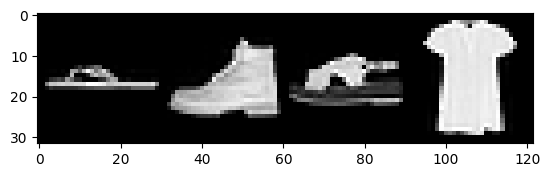

Predicted:  Sandal Ankle boot Sandal T-shirt/top
Ground truth:  Sandal Ankle boot Sandal Shirt
Accuracy of the network on the 10000 test images: 85 %


In [19]:
# Save the model
t.save(net.state_dict(), 'model.pth')

# Load the model
net = Net()
net.load_state_dict(t.load('model.pth'))

# Test the model
data = tv.datasets.FashionMNIST(root='./data', train=False, download=True, transform=tv.transforms.ToTensor())
data_loader = t.utils.data.DataLoader(data, batch_size=4, shuffle=True)
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Display the images
img = tv.utils.make_grid(images)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

# Get the model predictions
outputs = net(images)
_, predicted = t.max(outputs, 1)

# Print the model predictions
print('Predicted: ', ' '.join('%5s' % data.classes[predicted[j]] for j in range(4)))

# Print the ground truth
print('Ground truth: ', ' '.join('%5s' % data.classes[labels[j]] for j in range(4)))

# Test the model on the entire test set
correct = 0
total = 0
with t.no_grad():
    for data in data_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = t.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

# Test the model on each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with t.no_grad():
    for data in data_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = t.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


In [24]:

# Use the dataset object to access the classes attribute
dataset = tv.datasets.FashionMNIST(root='./data', train=False, download=True, transform=tv.transforms.ToTensor())

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (dataset.classes[i], 100 * class_correct[i] / class_total[i]))
    
# Log the accuracy to TensorBoard
writer.add_scalar('Accuracy', 100 * correct / total)

# Log the accuracy for each class to TensorBoard
for i in range(10):
    writer.add_scalar(dataset.classes[i], 100 * class_correct[i] / class_total[i])


Accuracy of T-shirt/top : 85 %
Accuracy of Trouser : 97 %
Accuracy of Pullover : 80 %
Accuracy of Dress : 85 %
Accuracy of  Coat : 81 %
Accuracy of Sandal : 97 %
Accuracy of Shirt : 49 %
Accuracy of Sneaker : 90 %
Accuracy of   Bag : 95 %
Accuracy of Ankle boot : 95 %


## Look at the results

Looking at the results you will see that one class is not being predicted well. This is the class of shirts. Why do you think this is?